# in this example we will use magpie

In [16]:
import numpy as np
import pandas as pd
df = pd.read_csv('training_data_no_features.csv')
print(len(df))
df = df.drop_duplicates(subset='FORMULA')
print(len(df))

28292
23230


In [17]:
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty

df = StrToComposition().featurize_dataframe(df, "FORMULA")
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df = ep_feat.featurize_dataframe(df, col_id="composition")  # input the "composition" column to the featurizer
df.head()

HBox(children=(IntProgress(value=0, description='StrToComposition', max=23230), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ElementProperty', max=23230), HTML(value='')))

,Unnamed: 0,FORMULA,PROPERTY: element A,PROPERTY: element B,PROPERTY: binary_classifier,PROPERTY: stabilityVec,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,0,Ac1,Ac,Ag,stable,1.0,(Ac),89.0,89.0,0.0,...,0.0,0.0,0.0,0.0,225.0,225.0,0.0,225.0,0.0,225.0
1,1,Ac0.9 Ag0.1,Ac,Ag,unstable,0.0,"(Ac, Ag)",47.0,89.0,42.0,...,0.0,0.0,0.0,0.0,225.0,225.0,0.0,225.0,0.0,225.0
2,2,Ac0.8 Ag0.2,Ac,Ag,unstable,0.0,"(Ac, Ag)",47.0,89.0,42.0,...,0.0,0.0,0.0,0.0,225.0,225.0,0.0,225.0,0.0,225.0
3,3,Ac0.7 Ag0.3,Ac,Ag,stable,1.0,"(Ac, Ag)",47.0,89.0,42.0,...,0.0,0.0,0.0,0.0,225.0,225.0,0.0,225.0,0.0,225.0
4,4,Ac0.6 Ag0.4,Ac,Ag,unstable,0.0,"(Ac, Ag)",47.0,89.0,42.0,...,0.0,0.0,0.0,0.0,225.0,225.0,0.0,225.0,0.0,225.0


In [18]:
# rows with noble gases don't have electroneg values populated, drop for now
df = df.dropna()
df.to_csv('magpie_featurized.csv')

In [90]:
df = pd.read_csv('magpie_featurized.csv')

In [91]:
counts = df['PROPERTY: stabilityVec'].value_counts()
unstable_count = counts[0]
stable_count = counts[1]
unstable_binaries = df[(df['PROPERTY: stabilityVec'] == 0) & (df['FORMULA'].str.contains('\.'))]
stable_binaries = df[(df['PROPERTY: stabilityVec'] == 1) & (df['FORMULA'].str.contains('\.'))]
print(len(stable_binaries))
print(len(unstable_binaries))
print(counts)

2493
18999
0.0    18999
1.0     2572
Name: PROPERTY: stabilityVec, dtype: int64


In [92]:
# https://github.com/hackingmaterials/matminer_examples/blob/master/matminer_examples/machine_learning-nb/bulk_modulus.ipynb
y = df['PROPERTY: stabilityVec'].values

excluded = ['Unnamed: 0', 'Unnamed: 0.1', 'FORMULA', 'composition' , 'PROPERTY: element A', 'PROPERTY: element B', 'PROPERTY: binary_classifier', 'PROPERTY: stabilityVec']
X = df.drop(excluded, axis=1)

print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))

There are 132 possible descriptors:

['MagpieData minimum Number' 'MagpieData maximum Number'
 'MagpieData range Number' 'MagpieData mean Number'
 'MagpieData avg_dev Number' 'MagpieData mode Number'
 'MagpieData minimum MendeleevNumber' 'MagpieData maximum MendeleevNumber'
 'MagpieData range MendeleevNumber' 'MagpieData mean MendeleevNumber'
 'MagpieData avg_dev MendeleevNumber' 'MagpieData mode MendeleevNumber'
 'MagpieData minimum AtomicWeight' 'MagpieData maximum AtomicWeight'
 'MagpieData range AtomicWeight' 'MagpieData mean AtomicWeight'
 'MagpieData avg_dev AtomicWeight' 'MagpieData mode AtomicWeight'
 'MagpieData minimum MeltingT' 'MagpieData maximum MeltingT'
 'MagpieData range MeltingT' 'MagpieData mean MeltingT'
 'MagpieData avg_dev MeltingT' 'MagpieData mode MeltingT'
 'MagpieData minimum Column' 'MagpieData maximum Column'
 'MagpieData range Column' 'MagpieData mean Column'
 'MagpieData avg_dev Column' 'MagpieData mode Column'
 'MagpieData minimum Row' 'MagpieData maximum 

In [93]:
nan_rows = df[df.isnull().any(1)]
print(len(nan_rows))
nan_rows.to_csv('nan_rows.csv')

0


In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

rf = RandomForestClassifier(n_estimators = len(X.columns), random_state=1)
rf.fit(X, y)
df['predicted_stabilityVec'] = rf.predict(X)

In [110]:
df.where(df['PROPERTY: stabilityVec'].values==df['predicted_stabilityVec'].values)


ValueError: Array conditional must be same shape as self

In [105]:

df.to_csv('predicted_test.csv')

In [106]:
# test data
df_test = pd.read_csv('test_data_magpie_featurized.csv')
excluded = ['Unnamed: 0', 'FORMULA', 'composition']
X_test = df_test.drop(excluded, axis=1)
print(len(X.columns), len(X_test.columns))
df_test['predicted_stabilityVec'] = rf.predict(X_test)
df_test = df_test.filter(['FORMULA', 'predicted_stabilityVec'], axis=1)
df_test.to_csv('test_data_predictions.csv')

132 132


In [107]:
print(df_test['predicted_stabilityVec'].value_counts())

0.0    5854
1.0     462
Name: predicted_stabilityVec, dtype: int64


In [73]:
df_equal = df['PROPERTY: stabilityVec'].equals(df['predicted_stabilityVec'])
df['result'] = np.where(df['PROPERTY: stabilityVec'] == df['predicted_stabilityVec'], 'correct', 'incorrect')
print(df['result'].value_counts())

correct      21406
incorrect      165
Name: result, dtype: int64


In [50]:
from sklearn.model_selection import KFold, cross_val_score
crossvalidation = KFold(n_splits=10, shuffle=False, random_state=1)

# compute cross validation scores for random forest model
r2_scores = cross_val_score(rf, X, y, scoring='r2', cv=crossvalidation, n_jobs=-1)
scores = cross_val_score(rf, X, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=-1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]

print('Cross-validation results:')
print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean R2: 0.983
Folds: 10, mean RMSE: 0.035


In [58]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(rf, X, y, cv=crossvalidation)
confusion_matrix(y, y_pred,)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
print(tn, fp, fn, tp)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
F_score = (2 * recall * precision) / (recall + precision)
print(recall, precision, F_score)

18999 0 42 2530
0.9836702954898912 1.0 0.9917679341434731


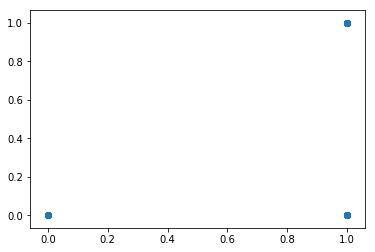

In [54]:
import matplotlib.pyplot as plt

plt.scatter(y, y_pred)